<a href="https://colab.research.google.com/github/Aman-Bhatt-0/Hate-Speech-Detection/blob/main/hatespeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


# **Importing Dataset**

In [4]:
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset

Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
License(s): CC0-1.0
hate-speech-and-offensive-language-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
zip_ref=zipfile.ZipFile('/content/hate-speech-and-offensive-language-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()


# **Importing Libraries**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# NLP tools
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# train split and models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Data Visualisation**

In [7]:
dataset = pd.read_csv('/content/labeled_data.csv')
dataset.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [9]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,24783.0,12681.192027,7299.553863,0.0,6372.5,12703.0,18995.5,25296.0
count,24783.0,3.243473,0.883060,3.0,3.0,3.0,3.0,9.0
hate_speech,24783.0,0.280515,0.631851,0.0,0.0,0.0,0.0,7.0
offensive_language,24783.0,2.413711,1.399459,0.0,2.0,3.0,3.0,9.0
neither,24783.0,0.549247,1.113299,0.0,0.0,0.0,0.0,9.0
class,24783.0,1.110277,0.462089,0.0,1.0,1.0,1.0,2.0


<ipython-input-10-66e831cb08bf>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=dataset, palette='viridis')


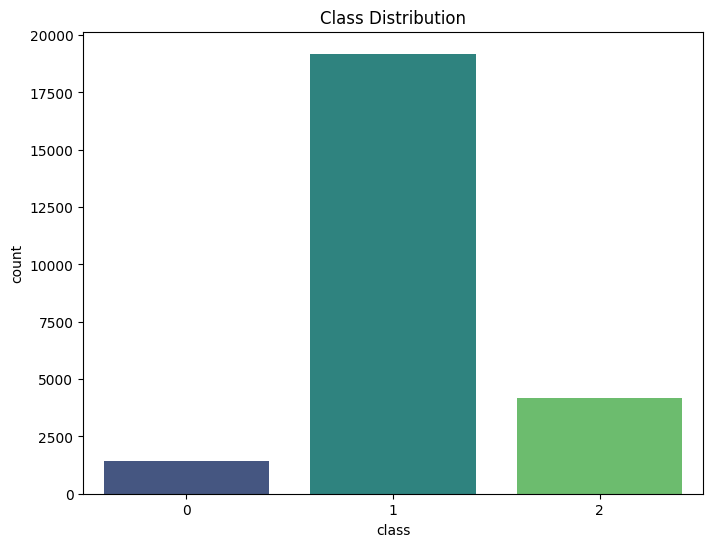

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=dataset, palette='viridis')
plt.title("Class Distribution")
plt.show()

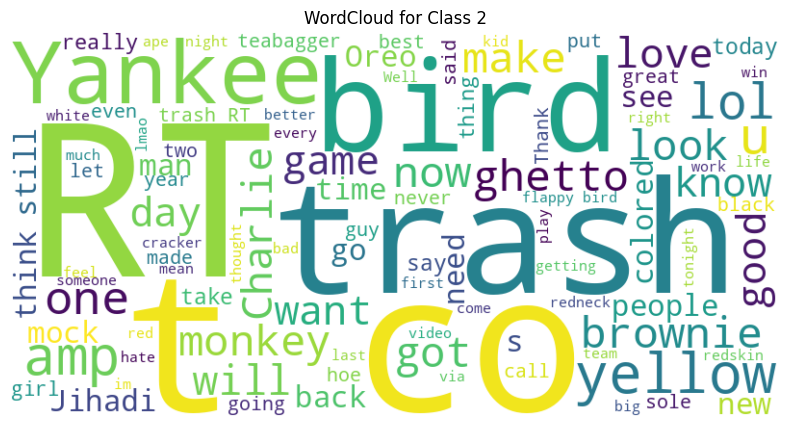

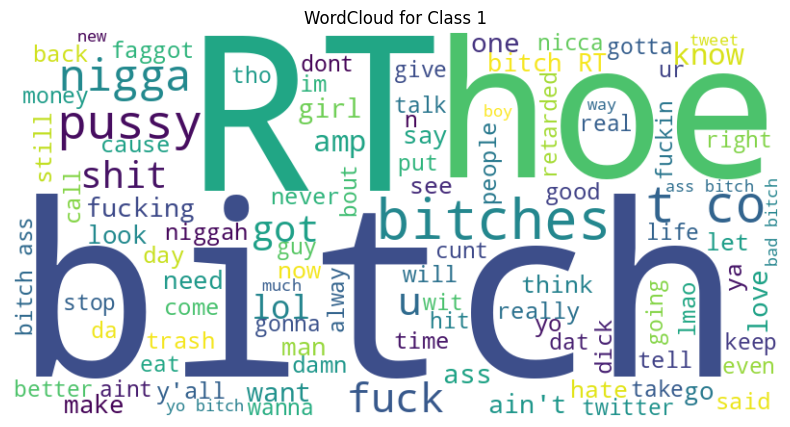

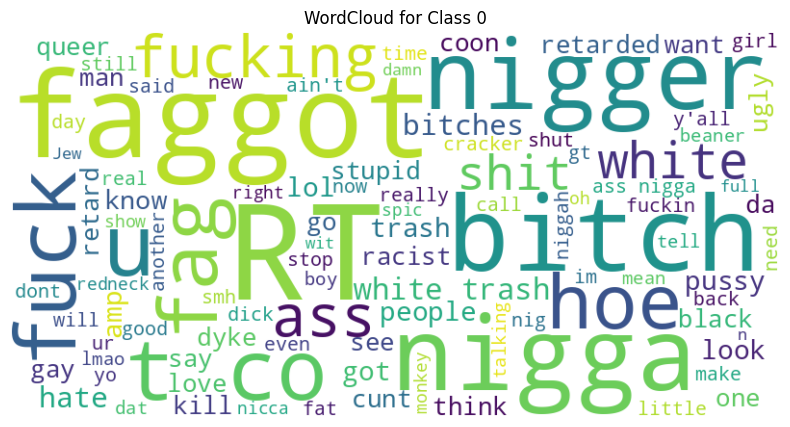

In [11]:
# WordCloud for each class
for label in dataset['class'].unique():
    subset = dataset[dataset['class'] == label]
    words = ' '.join(subset['tweet'])
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"WordCloud for Class {label}")
    plt.axis('off')
    plt.show()

In [15]:
dt_trasformed = dataset[['class', 'tweet']]
y = dt_trasformed.iloc[:, :-1].values

In [16]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], remainder='passthrough')
y = np.array(ct.fit_transform(y))

In [17]:
print(y)

[[0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [18]:
y_df = pd.DataFrame(y)
y_hate = np.array(y_df[0])
y_offensive = np.array(y_df[1])

In [19]:
print(y_hate)
print(y_offensive)

[0. 0. 0. ... 0. 0. 0.]
[0. 1. 1. ... 1. 1. 0.]


# **Cleaning text**

In [20]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
lemmatizer = WordNetLemmatizer()
corpus = []
for i in range(0, len(dataset)):
    review = re.sub('[^a-zA-Z]', ' ', dataset['tweet'][i])
    review = review.lower().split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    corpus.append(' '.join(review))


In [22]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(corpus).toarray()

# Label encoding
y = dataset['class']


# **Splitting the dataset into the Training set and Test set**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_hate, test_size = 0.20, random_state = 0)

# **Finding the best models to predict hate speech**

 **Native Bayes**

In [24]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
nb_score = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {nb_score:.4f}")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy: 0.5362
              precision    recall  f1-score   support

         0.0       0.96      0.53      0.68      4678
         1.0       0.07      0.58      0.12       279

    accuracy                           0.54      4957
   macro avg       0.51      0.56      0.40      4957
weighted avg       0.91      0.54      0.65      4957



**Decision Tree**

In [25]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
dt_score = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {dt_score:.4f}")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.9221
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      4678
         1.0       0.29      0.27      0.28       279

    accuracy                           0.92      4957
   macro avg       0.62      0.61      0.62      4957
weighted avg       0.92      0.92      0.92      4957



**Logistic Regression**

In [26]:
# **Logistic Regression**
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
lr_score = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_score:.4f}")
print(classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9461
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      4678
         1.0       0.62      0.11      0.19       279

    accuracy                           0.95      4957
   macro avg       0.78      0.55      0.58      4957
weighted avg       0.93      0.95      0.93      4957



**Random Froest**

In [27]:
# Best Random Forest model
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf_score = accuracy_score(y_test, y_pred_rf)
print(f"Random forest Accuracy: {rf_score:.4f}")
print(classification_report(y_test, y_pred_rf))


Random forest Accuracy: 0.9427
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      4678
         1.0       0.45      0.09      0.15       279

    accuracy                           0.94      4957
   macro avg       0.70      0.54      0.56      4957
weighted avg       0.92      0.94      0.92      4957



# **Making the Confusion Matrix for each model**

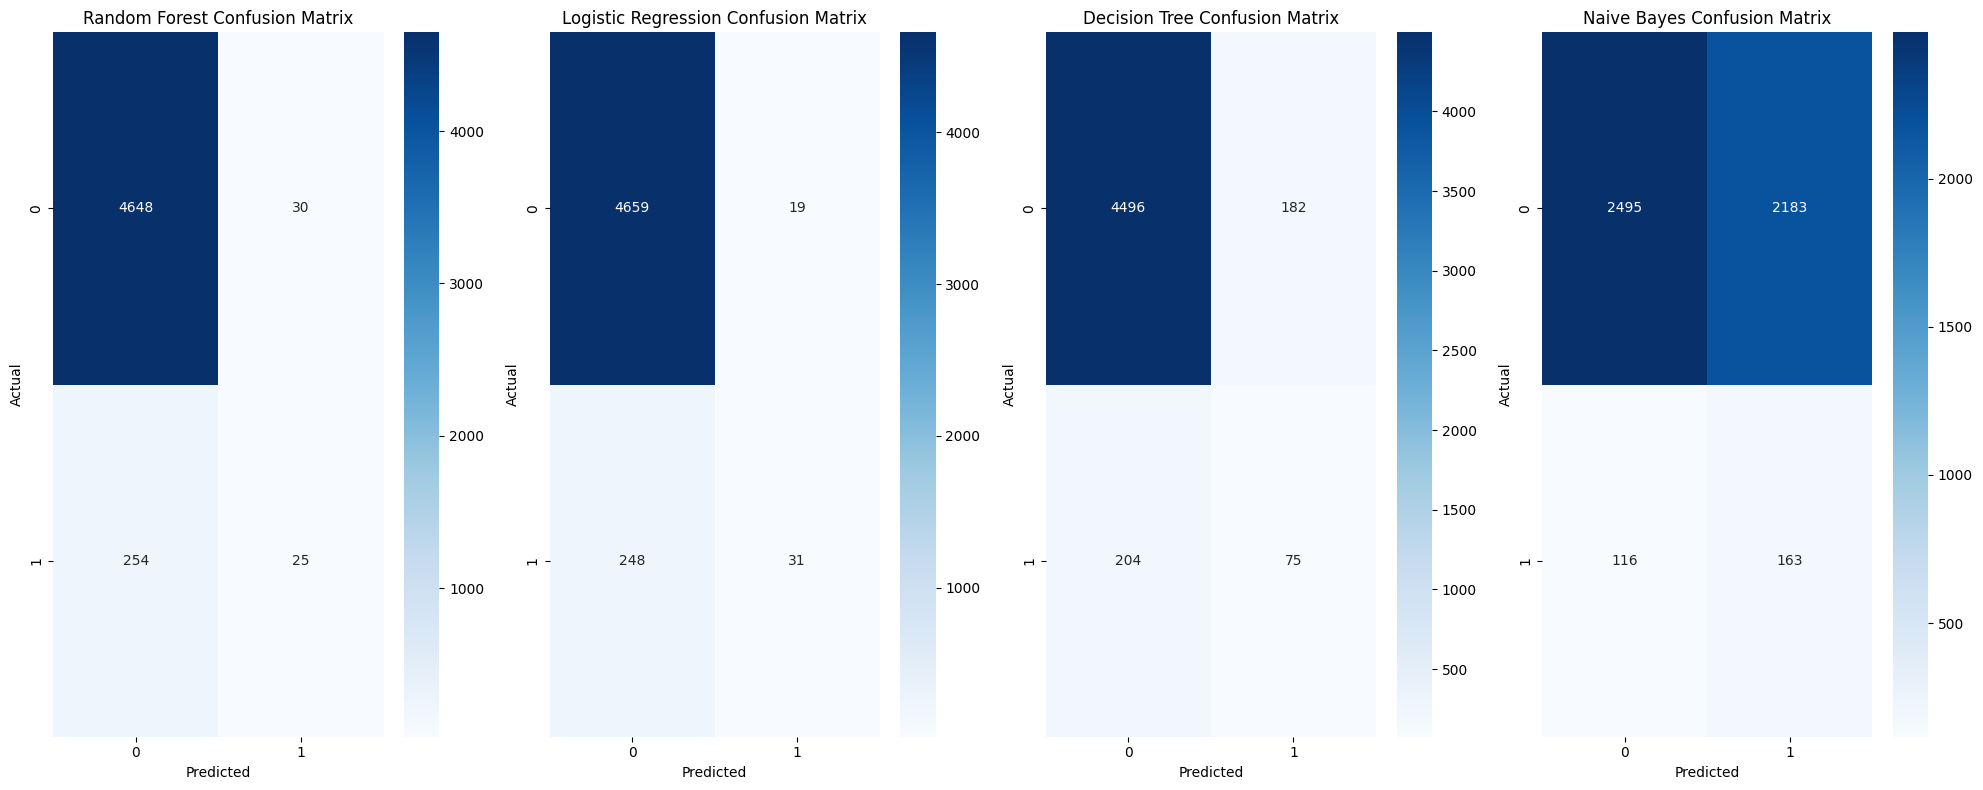

In [29]:
plt.figure(figsize=(20, 8))

for i, (model_name, y_pred) in enumerate([('Random Forest', y_pred_rf), ('Logistic Regression', y_pred_lr),
                                          ('Decision Tree', y_pred_dt), ('Naive Bayes', y_pred_nb)]):
    plt.subplot(1, 4, i+1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [32]:
def predict_text(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if not word in set(stopwords.words('english'))]
    text = ' '.join(text)
    vec_text = tfidf.transform([text]).toarray()

    prediction = rf.predict(vec_text)[0]
    label_map = {0: 'Hate Speech', 1: 'Offensive Language', 2: 'Neither'}
    return label_map[prediction]

# Example text prediction
sample_text = "I hate everyone!"
print(f"Predicted class for sample text: {predict_text(sample_text)}")

Predicted class for sample text: Hate Speech
